<a href="https://colab.research.google.com/github/kaurroopak/Summer-Analytics-2025---IIT-Guwahati/blob/main/SA2025_W4_AiPlanet_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nutrition Health Survey- Age Prediction Summer Analytics 2025, IIT Guwahati

##Week 4 Hackathon - AI Planet
###Submitted by - Roopakjeet Kaur (TIET)

Install required packages

In [4]:
!pip install xgboost lightgbm scikit-learn imbalanced-learn optuna shap -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import shap
import optuna


In [5]:
# Set random seed for reproducibility
np.random.seed(42)

1. DATA LOADING & PREPROCESSING

In [6]:
# Upload and load datasets
uploaded = files.upload()

train = pd.read_csv("Train_Data.csv")
test = pd.read_csv("Test_Data.csv")

# Convert target to binary
train['target'] = (train['age_group'] == 'Senior').astype(int)
y = train['target']

# Check class distribution
print("Class Distribution:\n", y.value_counts(normalize=True))

# Remove any potential leakage features
if 'Age' in train.columns:
    train = train.drop('Age', axis=1)

Saving Test_Data.csv to Test_Data (9).csv
Saving Train_Data.csv to Train_Data (9).csv
Class Distribution:
 target
0    0.840285
1    0.159715
Name: proportion, dtype: float64


2. FEATURE ENGINEERING

In [7]:
def create_features(df):
    df = df.copy()
    # Clinical ratios
    df['Glucose_Insulin_Ratio'] = df['LBXGLU'] / (df['LBXIN'] + 1e-6)
    df['HOMA_IR'] = (df['LBXGLU'] * df['LBXIN']) / 405  # Insulin resistance

    # Interaction terms
    df['BMI_Glucose'] = df['BMXBMI'] * df['LBXGLU']
    df['BMI_Insulin'] = df['BMXBMI'] * df['LBXIN']

    # Medical conditions
    df['High_Risk'] = ((df['BMXBMI'] > 30) &
                      (df['LBXGLU'] > 100) &
                      (df['DIQ010'] == 1)).astype(int)

    # Activity indicators
    df['Active_Lifestyle'] = (df['PAQ605'] == 1).astype(int)

    return df

train = create_features(train)
test = create_features(test)

# Selected features
features = ['RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010',
           'LBXGLT', 'LBXIN', 'Glucose_Insulin_Ratio', 'HOMA_IR',
           'BMI_Glucose', 'BMI_Insulin', 'High_Risk', 'Active_Lifestyle']

X = train[features].fillna(train[features].median())
test_processed = test[features].fillna(test[features].median())

3. MODEL OPTIMIZATION

In [8]:
# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Optuna hyperparameter tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
    }

    cv_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_res, y_res):
        X_train, X_val = X_res.iloc[train_idx], X_res.iloc[val_idx]
        y_train, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]

        model = XGBClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        cv_scores.append(f1_score(y_val, y_pred))

    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\nBest F1 Score:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-06-23 20:39:13,622] A new study created in memory with name: no-name-fc6a355d-ecea-42b4-be46-3239edc3aa93
[I 2025-06-23 20:39:18,029] Trial 0 finished with value: 0.7917251733695398 and parameters: {'n_estimators': 191, 'max_depth': 3, 'learning_rate': 0.038778284464692274, 'subsample': 0.7446791183303949, 'colsample_bytree': 0.6399688598181503, 'gamma': 0.35048487181988236, 'scale_pos_weight': 4.168770168944605}. Best is trial 0 with value: 0.7917251733695398.
[I 2025-06-23 20:39:21,766] Trial 1 finished with value: 0.8514411937882892 and parameters: {'n_estimators': 378, 'max_depth': 7, 'learning_rate': 0.027769886939406317, 'subsample': 0.7240993506645601, 'colsample_bytree': 0.73066912829609, 'gamma': 0.15138293403798236, 'scale_pos_weight': 3.7526473592919425}. Best is trial 1 with value: 0.8514411937882892.
[I 2025-06-23 20:39:23,736] Trial 2 finished with value: 0.8347795243753765 and parameters: {'n_estimators': 177, 'max_depth': 7, 'learning_rate': 0.0529865261658641, 


Best F1 Score: 0.8746196175744348
Best Parameters: {'n_estimators': 441, 'max_depth': 7, 'learning_rate': 0.1254330650921205, 'subsample': 0.8934497671320736, 'colsample_bytree': 0.7596151258267574, 'gamma': 0.08754504119565232, 'scale_pos_weight': 4.806835053340528}


4. ENSEMBLE MODEL TRAINING

In [9]:
best_params = study.best_params

# Initialize individual models
xgb = XGBClassifier(**best_params, random_state=42)
xgb.fit(X_res, y_res)  # Explicitly fit for SHAP analysis

lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    scale_pos_weight=len(y_res[y_res==0])/len(y_res[y_res==1])
)

# Create and fit ensemble
ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm)],
    voting='soft'
)
ensemble.fit(X_res, y_res)

# Cross-validation
cv_preds = np.zeros(len(X_res))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in skf.split(X_res, y_res):
    X_train, X_val = X_res.iloc[train_idx], X_res.iloc[val_idx]
    y_train, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]

    ensemble.fit(X_train, y_train)
    cv_preds[val_idx] = ensemble.predict(X_val)

print("\nEnsemble Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_res, cv_preds))
print("F1 Score:", f1_score(y_res, cv_preds))

[LightGBM] [Info] Number of positive: 1652, number of negative: 1652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2430
[LightGBM] [Info] Number of data points in the train set: 3304, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

5. THRESHOLD OPTIMIZATION


Optimal Threshold: 0.536
Max F1 at Threshold: 0.9768


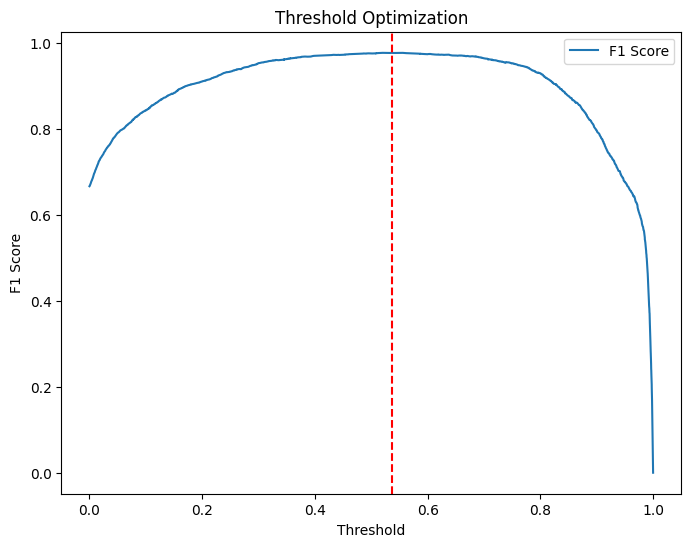

In [10]:
# Get validation probabilities
val_probs = ensemble.predict_proba(X_res)[:, 1]

# Find optimal F1 threshold
precisions, recalls, thresholds = precision_recall_curve(y_res, val_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.3f}")
print(f"Max F1 at Threshold: {f1_scores[optimal_idx]:.4f}")

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(optimal_threshold, color='red', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold Optimization')
plt.legend()
plt.show()

6. FEATURE IMPORTANCE

/tmp/ipython-input-11-4205427865.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_res, feature_names=features, show=False)


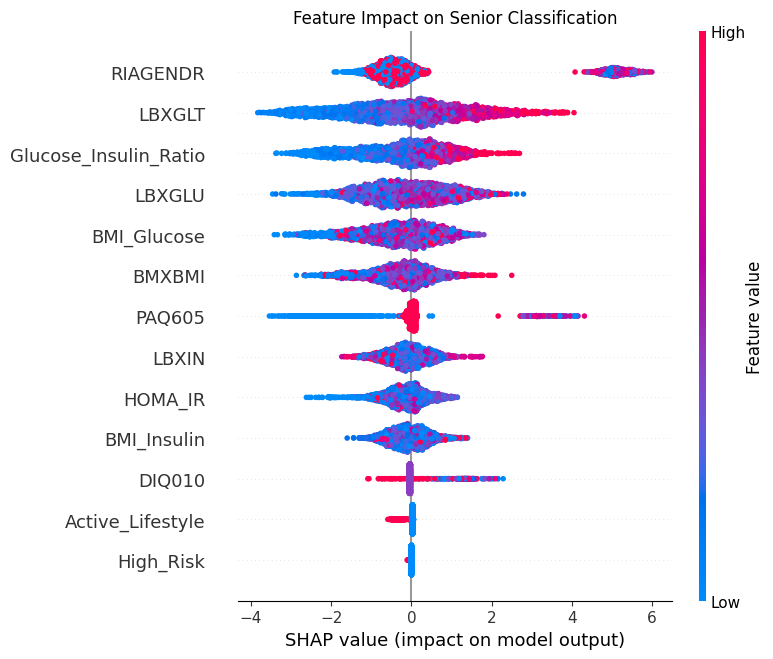


Top 5 Features:
                  Feature  Importance
1                  PAQ605    0.290363
0                RIAGENDR    0.202486
12       Active_Lifestyle    0.113285
7   Glucose_Insulin_Ratio    0.052182
5                  LBXGLT    0.048542


In [11]:
# SHAP Analysis (using the pre-fitted xgb model)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_res)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_res, feature_names=features, show=False)
plt.title('Feature Impact on Senior Classification', fontsize=12)
plt.tight_layout()
plt.show()

# Traditional feature importance
importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 5 Features:")
print(importance.head(5))

7. SUBMISSION GENERATION

In [12]:
# Generate test predictions
test_probs = ensemble.predict_proba(test_processed)[:, 1]
final_pred = (test_probs > optimal_threshold).astype(int)

# Validate submission
assert len(final_pred) == len(test), "Prediction length mismatch"
print("\nSubmission Class Distribution:")
print(pd.Series(final_pred).value_counts(normalize=True))

# Save submission
submission = pd.DataFrame({'age_group': final_pred})
submission.to_csv('submission.csv', index=False)

# Download
from google.colab import files
files.download('submission.csv')

print("\nSubmission file created successfully!")


Submission Class Distribution:
0    0.833333
1    0.166667
Name: proportion, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Submission file created successfully!
